# 📊 Telecom Customer Churn Prediction

## 🎯 Problem Statement
A leading telecom company wants to identify customers who are likely to **churn** (i.e., discontinue their service).  
The goal is to build a **machine learning model** that predicts churn based on customer demographics, account information, and service usage patterns.

By accurately identifying high-risk customers, the company can design **targeted retention strategies**, reduce churn rate, and increase overall customer lifetime value.

---

## 🧾 Business Objectives
- Understand which factors most influence churn (e.g., contract type, monthly charges, tenure).  
- Quantify the impact of these factors using **statistical and predictive modeling**.  
- Build a **classification model** that can predict whether a customer will churn.  
- Create **actionable insights** and visualizations to support data-driven decisions.

---

## 🧰 Dataset Overview
Each record represents a customer and includes:
- **Demographic features:** Gender, SeniorCitizen, Partner, Dependents  
- **Service-related features:** InternetService, TechSupport, StreamingTV, Contract, PaymentMethod  
- **Account features:** Tenure, MonthlyCharges, TotalCharges  
- **Target variable:** `Churn` (Yes/No)

---

## 💡 Expected Outcomes
- A trained model that predicts churn probability for each customer.  
- Ranked feature importance showing top churn drivers.  
- Clear, data-backed recommendations for reducing churn (e.g., improve customer onboarding, adjust pricing).  
- Final deliverables: Notebook, Model pipeline, SQL insights, Tableau dashboard.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import pickle

In [5]:
df = pd.read_csv('Teleco.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.shape

(7043, 21)

- There are 7043 records in this dataset and 21 columns

In [10]:
#Check statistical summary

df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


- There are total 7043 records in this dataset
- Based on the summary there are no outliers in the dataset
- Minumum and maximum monthly charges are 18.25 and 118.75, these amounts make sense for telecom chargers
- Min tenure is 0 and max is 72 months

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- Here Dtype TotalCharges column is object which is incorrect so changing it to float64

In [16]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df['TotalCharges'].dtype

dtype('float64')

In [18]:
#Check null values in the dataset

df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [20]:
#Filling missing TotalCharges by multiplying tenure x MonthlyCharges

df['TotalCharges'] = df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'])

In [22]:
df['TotalCharges'].isnull().sum()

0

<h1 style="color: #1E88E5; padding: 15px; border-left: 5px solid #1E88E5;">
    📊 Exploratory Data Analysis (EDA)

In [27]:
#Define numerical and categorical cols

numerical_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                    'PaperlessBilling', 'PaymentMethod', 'Churn']

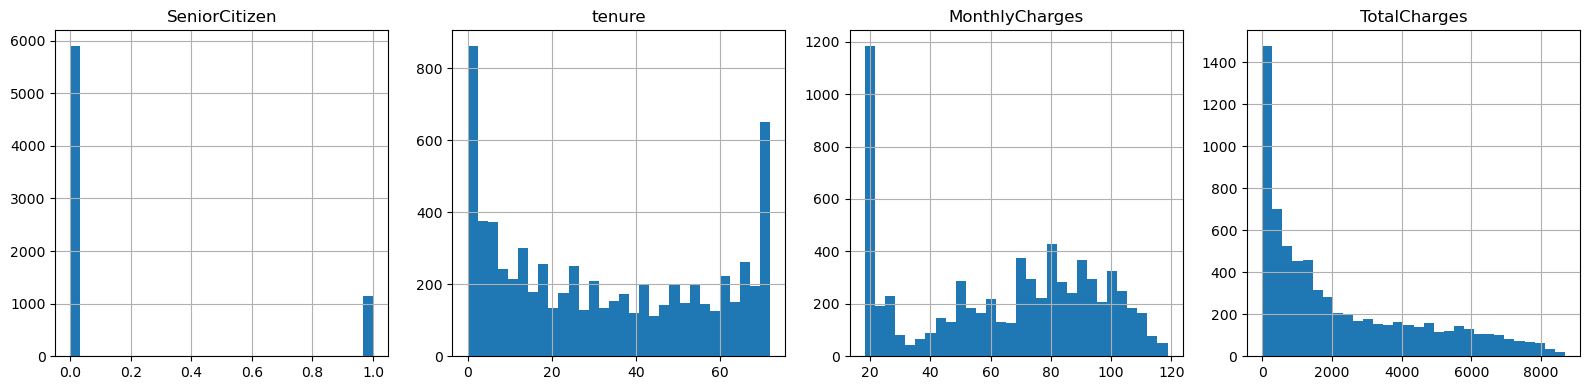

In [29]:
# Numerical columns - histograms
fig, axes = plt.subplots(nrows=(len(numerical_cols)+3)//4, ncols=4, figsize=(16, 4*((len(numerical_cols)+3)//4)))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(col)
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Numerical Features Analysis1. SeniorCitizen

Highly imbalanced: ~85% are non-senior citizens (0), only ~15% are seniors (1)
Most customers are younger adults
2. Tenure

Bimodal distribution with two peaks:

Large spike at 0-5 months (new customers)
Another peak at 70+ months (long-term loyal customers)


Suggests high early churn and a loyal customer base that stays long-term
Middle tenure (20-60 months) is less common
3. MonthlyCharges

Right-skewed distribution
Large concentration around 20-30 (basic plans)
Gradually decreases as charges increase
Peak around 70-80 (premium plans)
Range: ~20 to $120
4. TotalCharges

Heavily right-skewed
Most customers have low total charges (<2000)
Long tail extending to 8000+
Correlates with tenure (new customers = lower total charges)

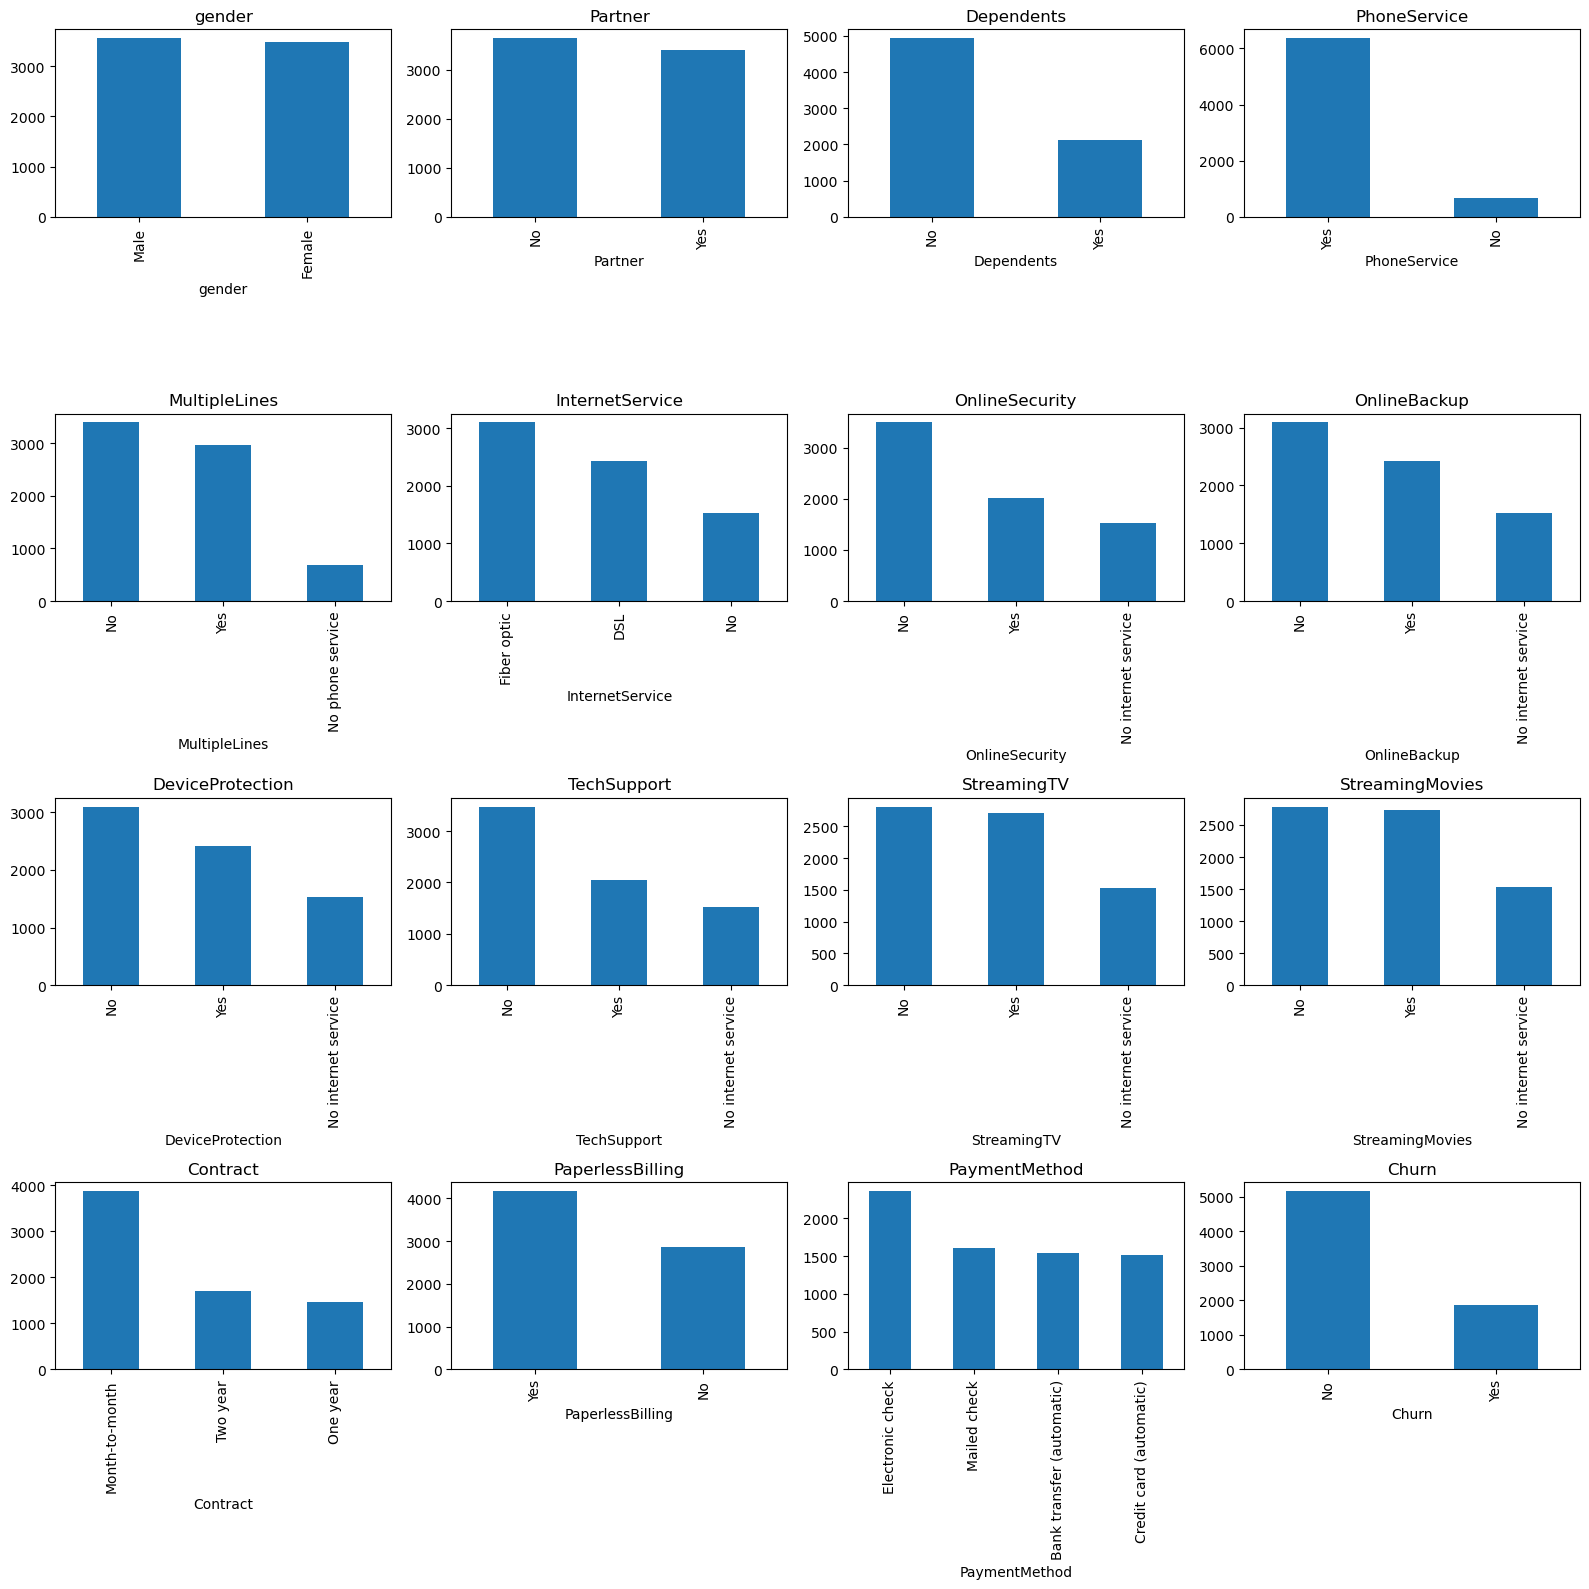

In [32]:
# Categorical columns - bar plots
fig, axes = plt.subplots(nrows=(len(categorical_cols)+3)//4, ncols=4, figsize=(16, 4*((len(categorical_cols)+3)//4)))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()


Categorical Features Analysis
Demographics:

Gender: Nearly balanced (50/50 Male/Female)
Partner: Slight majority have no partner (52% vs 48%)
Dependents: Majority have no dependents (70% vs 30%)

Services:

PhoneService: 90% have phone service (core product)
MultipleLines: Among phone users, 50% have single line, 40% no lines, 10% multiple
InternetService:

Fiber optic is most popular (43%)
DSL second (34%)
23% have no internet service



Add-on Services (mostly "No"):

OnlineBackup: 45% don't have it
DeviceProtection: 44% don't have it
TechSupport: 50% don't have it
StreamingTV: 38% have it, 38% don't, 24% no internet
StreamingMovies: Similar distribution to StreamingTV

Contract & Billing:

Contract: Month-to-month dominates (55%), then Two-year (24%), then One-year (21%)
PaperlessBilling: 60% use paperless billing
PaymentMethod: Electronic check is most common (33%), followed by automatic payments (25% each), credit card (22%)

Target Variable:

Churn: Imbalanced - 73% stayed (No), 27% churned (Yes)

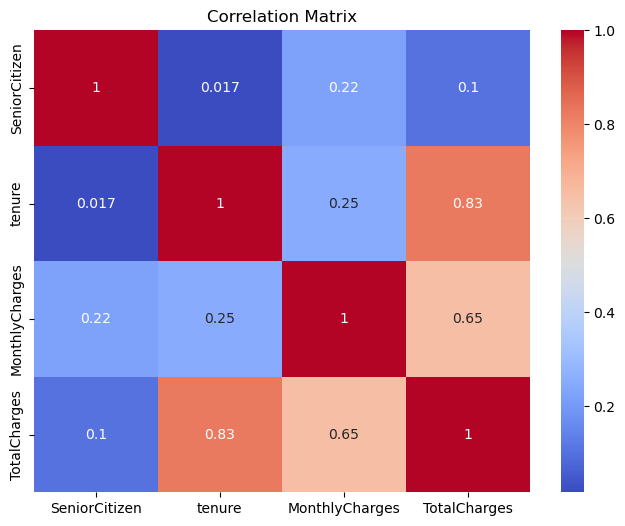

In [35]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Correlation Matrix Key Insights:
Strong Correlations:

tenure ↔ TotalCharges (0.83): Longer customers = higher total spending (expected)
MonthlyCharges ↔ TotalCharges (0.65): Higher monthly plans = higher total charges

Weak Correlations:

tenure ↔ MonthlyCharges (0.25): Long-term customers pay slightly more
SeniorCitizen ↔ MonthlyCharges (0.22): Seniors have slightly higher bills
SeniorCitizen ↔ tenure/TotalCharges (0.1): Age barely affects loyalty or spending

Key Takeaways:

No numerical feature strongly predicts tenure/retention
Must rely on categorical features (Contract, PaymentMethod, Services) for churn prediction
Consider creating new features: service adoption count, charge ratios, tenure segments

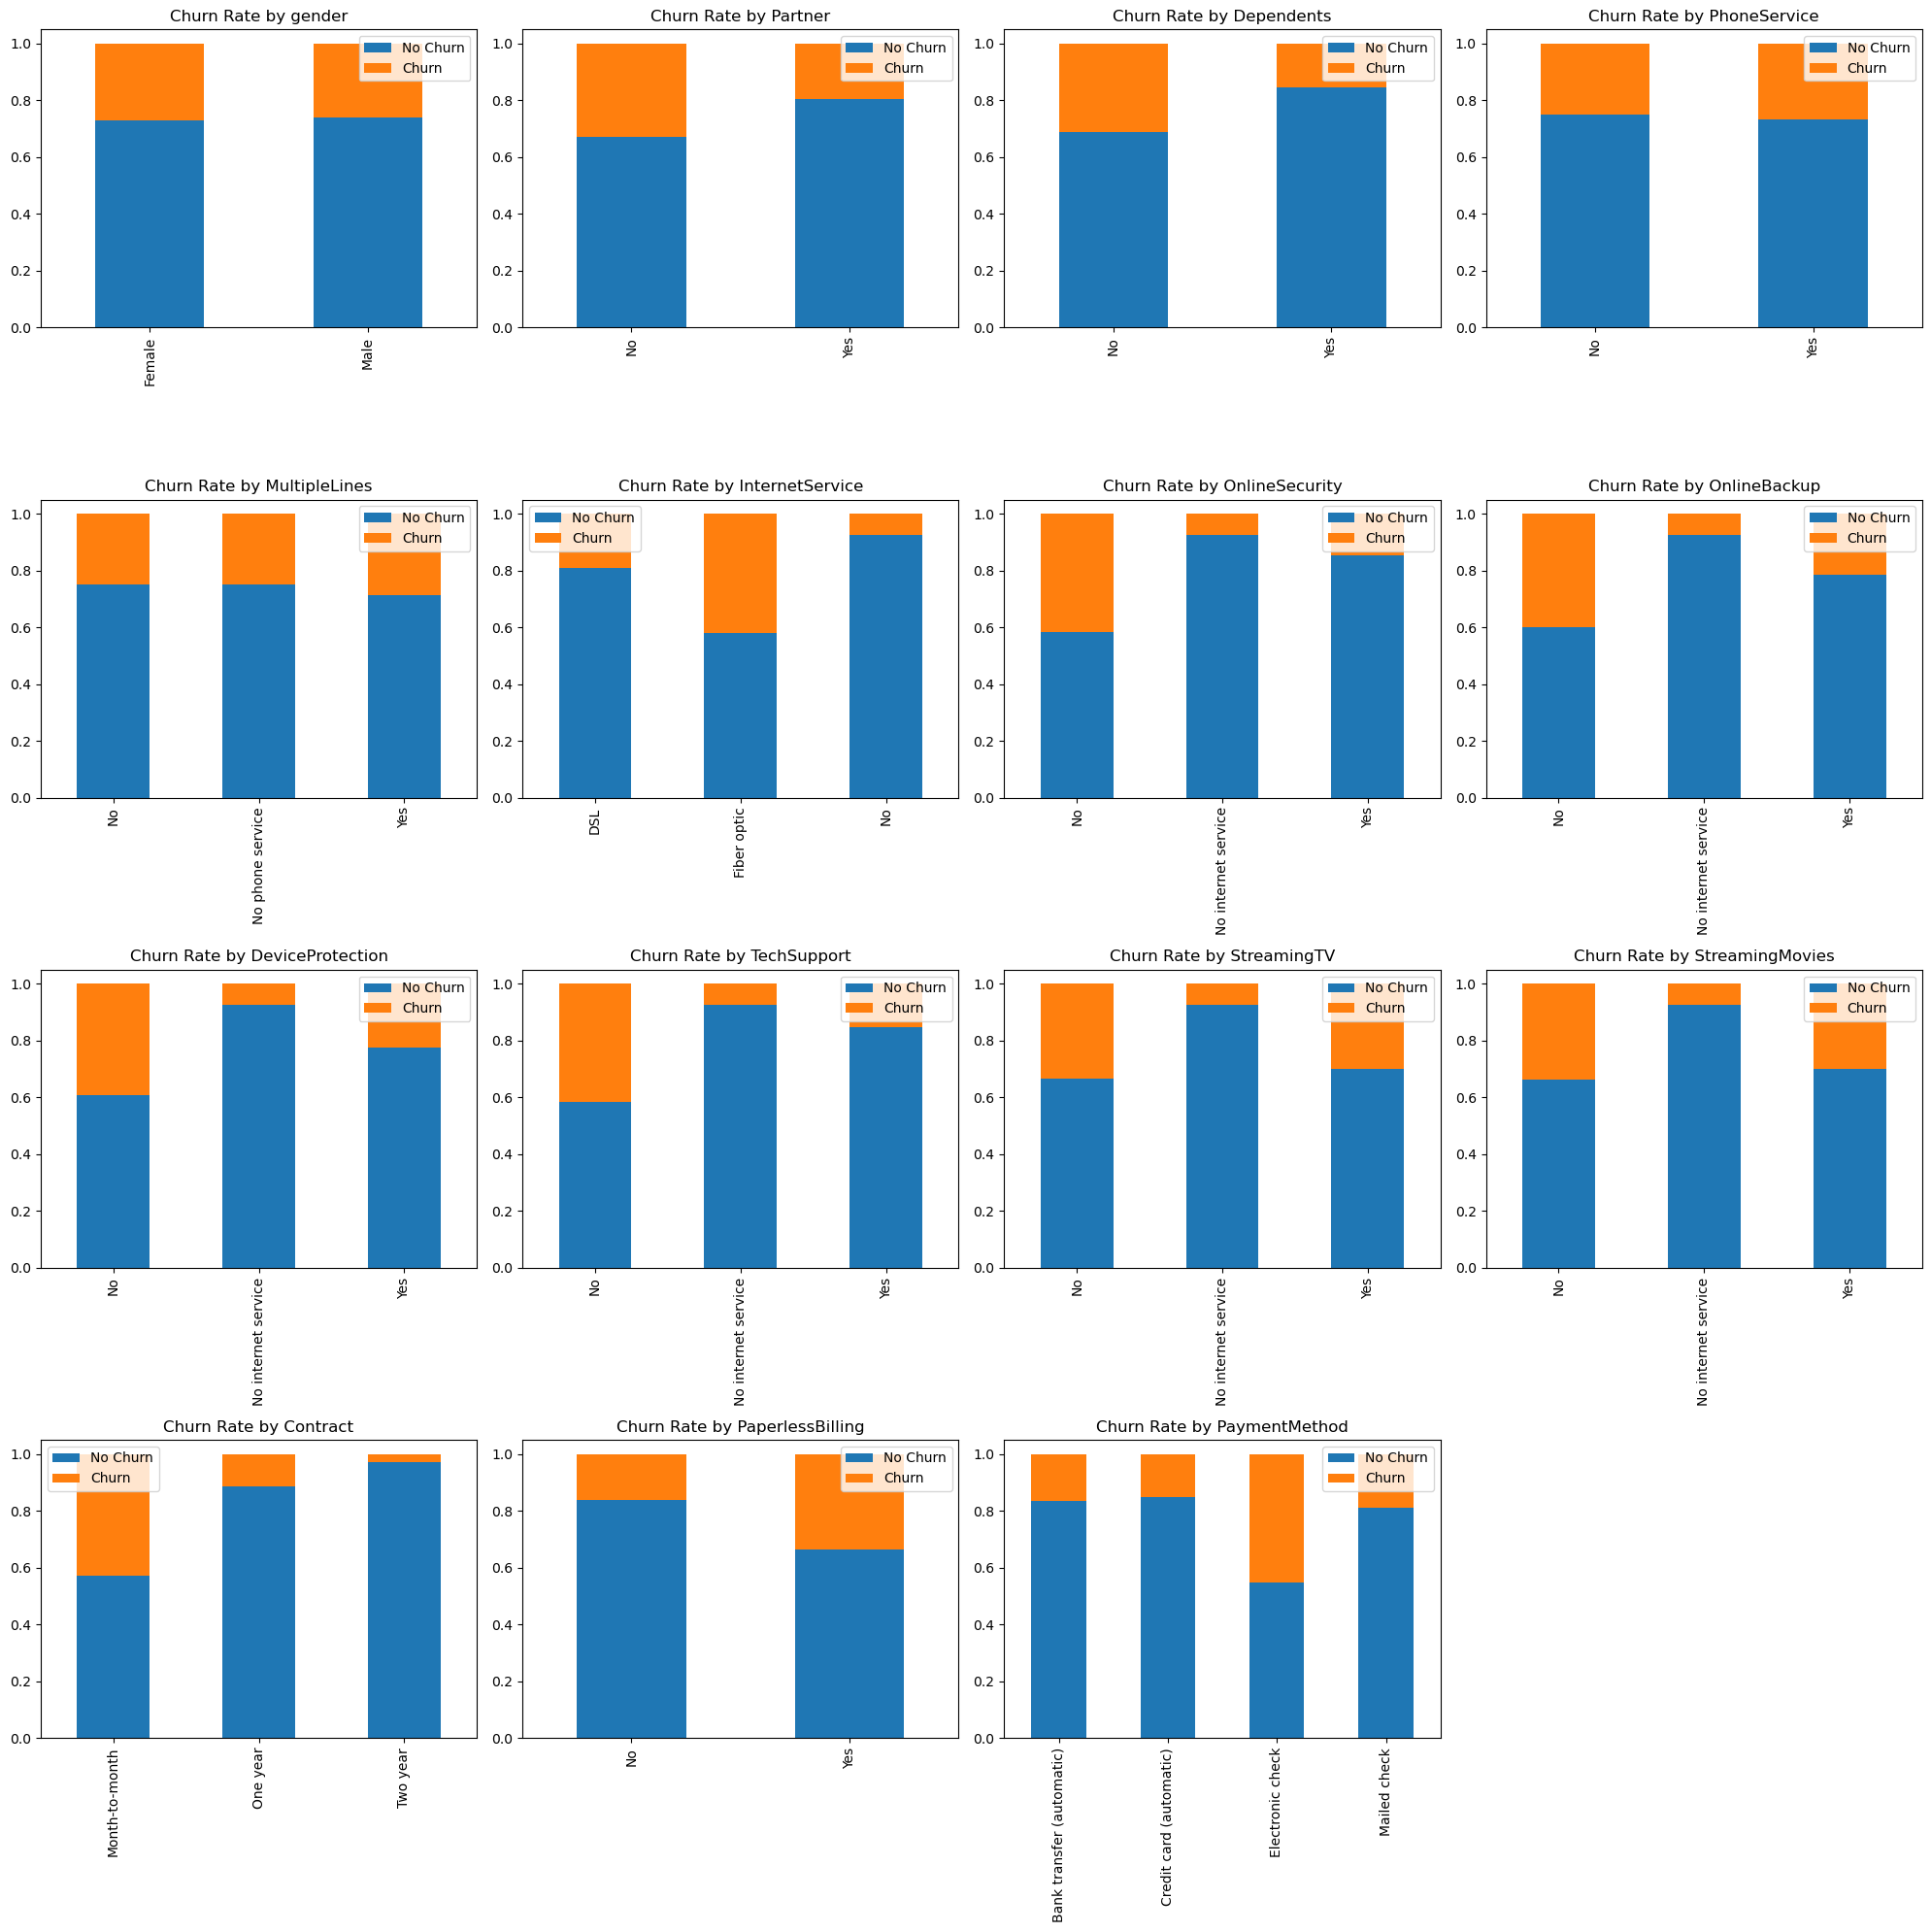

In [38]:
# 1. CATEGORICAL vs CHURN - 4 plots per row
categorical_cols_no_churn = [col for col in categorical_cols if col != 'Churn']

n_cols = 4
n_rows = (len(categorical_cols_no_churn) + 3) // 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols_no_churn):
    churn_rate = pd.crosstab(df[col], df['Churn'], normalize='index')
    churn_rate.plot(kind='bar', ax=axes[i], stacked=True)
    axes[i].set_title(f'Churn Rate by {col}')
    axes[i].set_xlabel('')
    axes[i].legend(['No Churn', 'Churn'])
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

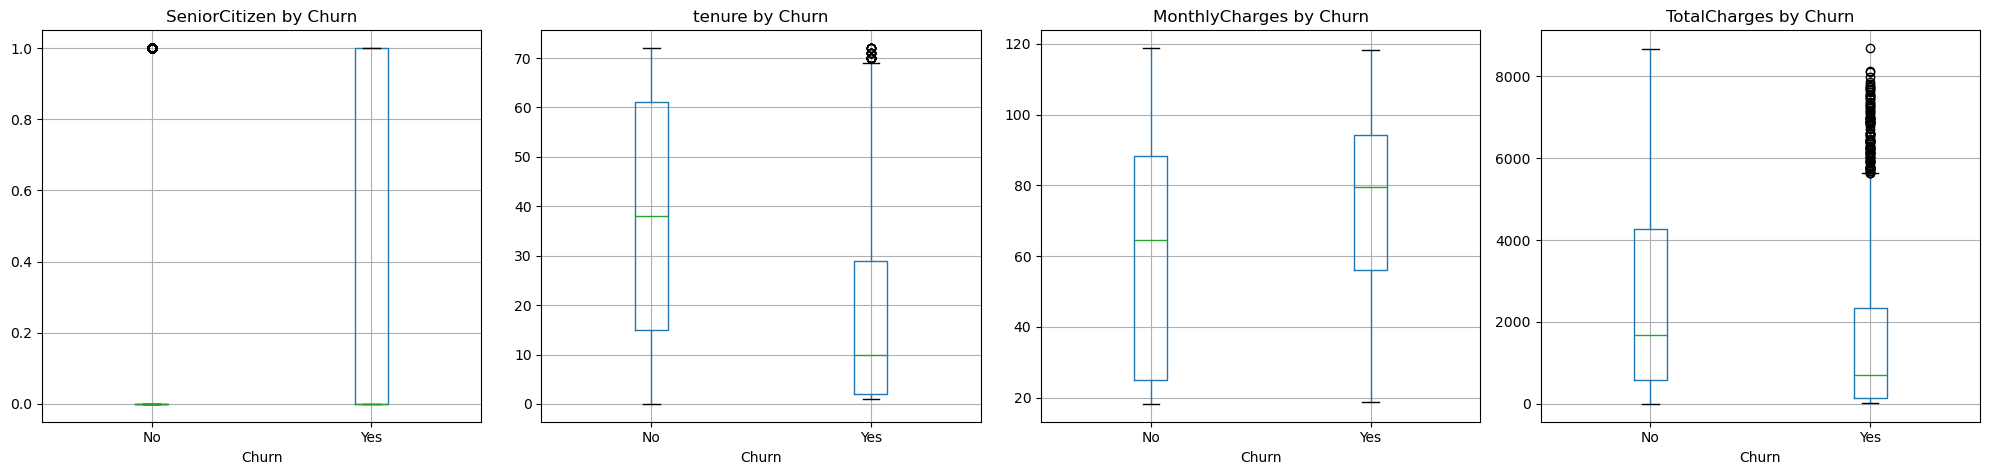

In [40]:
# 2. NUMERICAL vs CHURN - 4 plots per row
n_rows = (len(numerical_cols) + 3) // 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df.boxplot(column=col, by='Churn', ax=axes[i])
    axes[i].set_title(f'{col} by Churn')
    axes[i].set_xlabel('Churn')
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('')
plt.tight_layout()
plt.show()

## Churn Analysis - Key Insights

### **Demographics**
- **Gender**: No significant difference in churn rates (27% for both)
- **Partner**: Customers without partners have higher churn (33% vs 20%)
- **Dependents**: Customers without dependents churn more (31% vs 16%)
- **Senior Citizens**: Minimal impact on churn

### **Services**
- **InternetService**: Fiber optic shows highest churn (42%), DSL lower (19%), No internet lowest (7%)
- **Add-on Services**: Customers without OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport have significantly higher churn (40% vs 15%)
- **Phone Services**: Minimal impact on churn rates

### **Contract & Payment - Strongest Predictors**
- **Contract Type**: Month-to-month has 42% churn, One-year 11%, Two-year 3%
- **PaymentMethod**: Electronic check shows highest churn (45%), automatic payments lowest (15-18%)
- **PaperlessBilling**: Paperless customers churn more (33% vs 16%)

### **Numerical Features**
- **Tenure**: Churned customers have significantly lower tenure (median 10 months vs 38 months)
- **MonthlyCharges**: Churned customers pay slightly higher monthly charges (median 80 vs 65)
- **TotalCharges**: Churned customers have lower total charges due to shorter tenure

### **Key Findings**
- Contract type and payment method are the strongest churn predictors
- Customers without add-on services are at higher risk
- Early tenure period (<12 months) is critical for retention

<h1 style="color: #43A047; padding: 15px; border-left: 5px solid #43A047;">
    🔧 Feature Engineering

In [47]:

#Create new features

# 1. TENURE-BASED FEATURES
# From SQL: 0-12 months = 47% churn (high risk!)
df['IsNewCustomer'] = (df['tenure'] <= 12).astype(int)
df['IsEstablished'] = ((df['tenure'] > 12) & (df['tenure'] <= 24)).astype(int)
df['IsLoyalCustomer'] = (df['tenure'] > 48).astype(int)

# 2. CHARGE-BASED FEATURES
# From SQL: Higher monthly charges → more churn
df['ChargePerTenureMonth'] = df['TotalCharges'] / (df['tenure'] + 1)
df['IsHighSpender'] = (df['MonthlyCharges'] > 70).astype(int)
df['ChargeTenureRatio'] = df['MonthlyCharges'] / (df['tenure'] + 1)

# 3. SERVICE BUNDLE FEATURES
# Count total services
df['TotalServices'] = (
    (df['PhoneService'] == 'Yes').astype(int) +
    (df['InternetService'] != 'No').astype(int) +
    (df['OnlineSecurity'] == 'Yes').astype(int) +
    (df['OnlineBackup'] == 'Yes').astype(int) +
    (df['DeviceProtection'] == 'Yes').astype(int) +
    (df['TechSupport'] == 'Yes').astype(int) +
    (df['StreamingTV'] == 'Yes').astype(int) +
    (df['StreamingMovies'] == 'Yes').astype(int)
)

# Service density (services per month of tenure)
df['ServiceDensity'] = df['TotalServices'] / (df['tenure'] + 1)

# Has minimal services (risky!)
df['HasMinimalServices'] = (df['TotalServices'] <= 2).astype(int)

# 4. HIGH-RISK PROFILE COMBINATIONS
# From SQL: Month-to-month + Fiber + Electronic check = 54% churn!
df['HighRiskProfile'] = (
    (df['Contract'] == 'Month-to-month') & 
    (df['InternetService'] == 'Fiber optic') & 
    (df['PaymentMethod'] == 'Electronic check')
).astype(int)

# Senior without support (41% vs 15% churn)
df['SeniorNoSupport'] = (
    (df['SeniorCitizen'] == 1) & 
    (df['TechSupport'] == 'No')
).astype(int)

# No partner, no dependents (34% churn)
df['SingleNoFamily'] = (
    (df['Partner'] == 'No') & 
    (df['Dependents'] == 'No')
).astype(int)

# Short tenure + high charges (risky combo)
df['NewHighSpender'] = (
    (df['tenure'] <= 12) & 
    (df['MonthlyCharges'] > 70)
).astype(int)

# 5. PAYMENT & BILLING FEATURES
# Paperless + Electronic check (both high churn)
df['PaperlessElectronicCheck'] = (
    (df['PaperlessBilling'] == 'Yes') & 
    (df['PaymentMethod'] == 'Electronic check')
).astype(int)

# Has automatic payment
df['HasAutoPay'] = df['PaymentMethod'].isin([
    'Bank transfer (automatic)', 
    'Credit card (automatic)'
]).astype(int)

# 6. INTERNET SERVICE QUALITY INDICATORS
# Fiber optic but no add-ons (dissatisfied?)
df['FiberNoAddons'] = (
    (df['InternetService'] == 'Fiber optic') & 
    (df['OnlineSecurity'] == 'No') & 
    (df['TechSupport'] == 'No')
).astype(int)


In [49]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TotalServices,ServiceDensity,HasMinimalServices,HighRiskProfile,SeniorNoSupport,SingleNoFamily,NewHighSpender,PaperlessElectronicCheck,HasAutoPay,FiberNoAddons
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,2,1.000000,1,0,0,0,0,1,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,4,0.114286,0,0,0,1,0,0,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,4,1.333333,0,0,0,1,0,0,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,4,0.086957,0,0,0,1,0,0,1,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,2,0.666667,1,1,0,1,1,1,0,1


In [51]:
# # Purpose: Convert categorical variables to numerical format for ML models
# Date: [Your Date]
# Dataset: Telecom Customer Churn

# --------------------------------------------
# 1. BINARY ENCODING (Yes/No, Male/Female)
# --------------------------------------------
# Encoding: No=0, Yes=1 | Female=0, Male=1

df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})  # Check spelling!
df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# --------------------------------------------
# 2. HANDLE "NO SERVICE" CATEGORIES
# --------------------------------------------
# Replace "No internet/phone service" with "No" for consistency
# Rationale: Customer doesn't have the service = same as not opting in

df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
df['OnlineSecurity'] = df['OnlineSecurity'].replace('No internet service', 'No')
df['OnlineBackup'] = df['OnlineBackup'].replace('No internet service', 'No')  # Added
df['DeviceProtection'] = df['DeviceProtection'].replace('No internet service', 'No')
df['TechSupport'] = df['TechSupport'].replace('No internet service', 'No')
df['StreamingTV'] = df['StreamingTV'].replace('No internet service', 'No')
df['StreamingMovies'] = df['StreamingMovies'].replace('No internet service', 'No')

# Now encode to binary (No=0, Yes=1)

df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0})
df['OnlineSecurity'] = df['OnlineSecurity'].map({'Yes': 1, 'No': 0})
df['OnlineBackup'] = df['OnlineBackup'].map({'Yes': 1, 'No': 0})  # Added
df['DeviceProtection'] = df['DeviceProtection'].map({'Yes': 1, 'No': 0})
df['TechSupport'] = df['TechSupport'].map({'Yes': 1, 'No': 0})
df['StreamingTV'] = df['StreamingTV'].map({'Yes': 1, 'No': 0})
df['StreamingMovies'] = df['StreamingMovies'].map({'Yes': 1, 'No': 0})

# --------------------------------------------
# 3. ORDINAL ENCODING (Contract has natural order)
# --------------------------------------------
# Month-to-month (0) < One year (1) < Two year (2)
# Rationale: Longer contracts indicate more commitment

df['Contract'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

# --------------------------------------------
# 4. ONE-HOT ENCODING (Nominal categories, no order)
# --------------------------------------------
# InternetService: DSL, Fiber optic, No (3 categories)
# PaymentMethod: 4 payment types
# drop_first=True: Avoids multicollinearity (dummy variable trap)
# dtype=int: Creates 0/1 instead of True/False

df = pd.get_dummies(df, columns=['InternetService', 'PaymentMethod'], drop_first=True)

In [55]:
# Get all boolean columns
bool_cols = df.select_dtypes(include=['bool']).columns

# Convert to int
df[bool_cols] = df[bool_cols].astype(int)


In [57]:

# Select numerical columns to scale
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Initialize scaler
scaler = StandardScaler()

# Fit and transform
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [59]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,SingleNoFamily,NewHighSpender,PaperlessElectronicCheck,HasAutoPay,FiberNoAddons,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,-1.277445,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,0.066327,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,3668-QPYBK,1,0,0,0,-1.236724,1,0,1,1,...,1,0,0,0,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,0.514251,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,9237-HQITU,0,0,0,0,-1.236724,1,0,0,0,...,1,1,1,0,1,1,0,0,1,0


In [61]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nAny nulls?", df.isnull().sum().sum())

Shape: (7043, 40)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'IsNewCustomer', 'IsEstablished', 'IsLoyalCustomer', 'ChargePerTenureMonth', 'IsHighSpender', 'ChargeTenureRatio', 'TotalServices', 'ServiceDensity', 'HasMinimalServices', 'HighRiskProfile', 'SeniorNoSupport', 'SingleNoFamily', 'NewHighSpender', 'PaperlessElectronicCheck', 'HasAutoPay', 'FiberNoAddons', 'InternetService_Fiber optic', 'InternetService_No', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

Any nulls? 0


In [70]:
# Drop customerID (no predictive value)
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)
    print("customerID removed!")

customerID removed!


<h1 style="color: #FB8C00; padding: 15px; border-left: 5px solid #FB8C00;">
    ⚙️ Model Building

In [76]:
#defining features, x & y

x = df.drop('Churn', axis=1)
y = df['Churn']

#Train test split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

# Verify the split
print(f"Training set: {x_train.shape}")
print(f"Test set: {x_test.shape}")
print(f"\nTrain class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nTest class distribution:\n{y_test.value_counts(normalize=True)}")

Training set: (5634, 38)
Test set: (1409, 38)

Train class distribution:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Test class distribution:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64



Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


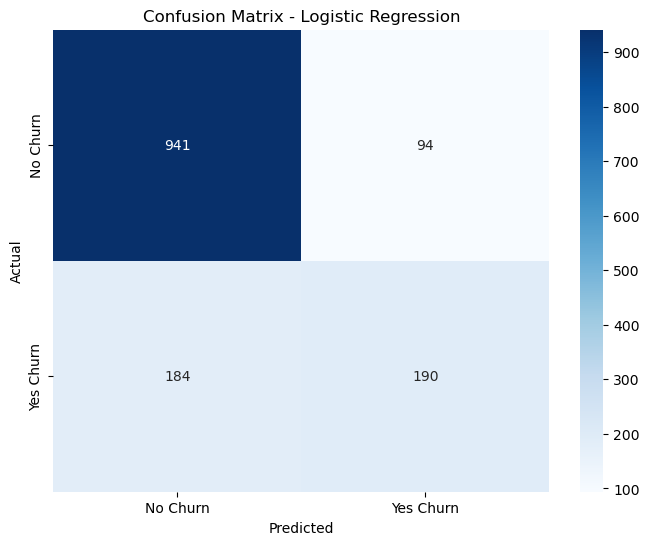

In [78]:
#Logistic Regression model

#Step 1: Initialize the model
lr = LogisticRegression(random_state=42, max_iter=1000)

#Step 2: Train model
lr.fit(x_train, y_train)

#Step 3: Make prediction
y_pred = lr.predict(x_test)

#Step 4: 

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Yes Churn'],
            yticklabels=['No Churn', 'Yes Churn'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.55      0.76      0.64       374

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409



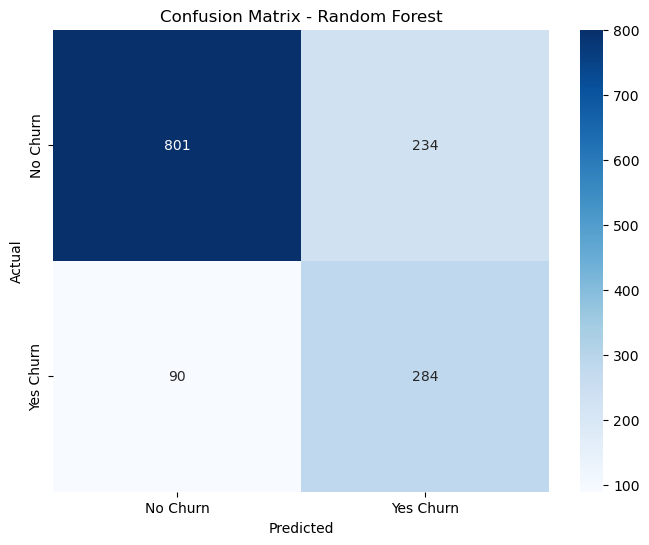

In [80]:

#Random forest model

#Step 1: Initialize the model
rf = RandomForestClassifier(
    random_state=42,
    n_estimators=200,        # More trees
    max_depth=10,            # Control overfitting
    min_samples_split=20,    # Minimum samples to split
    min_samples_leaf=10,     # Minimum samples in leaf
    class_weight='balanced'  # Handle class imbalance!
)
#Step 2: Train model
rf.fit(x_train, y_train)

#Step 3: Make prediction
y_pred = rf.predict(x_test)

#Step 4: 

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Yes Churn'],
            yticklabels=['No Churn', 'Yes Churn'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [106]:
from xgboost import XGBClassifier

# Initialize XGBoost with parameters for imbalanced data
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # Handle imbalance!
    eval_metric='logloss'
)

# Train
xgb_model.fit(x_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(x_test)

# Evaluate

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.53      0.79      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.76      0.77      1409



In [94]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_xgb = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [2.5, 2.77, 3.0]  # Around your class imbalance ratio
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions=param_dist_xgb,
    n_iter=30,
    cv=3,
    scoring='recall',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Tuning XGBoost... (5-10 minutes)")
xgb_random.fit(x_train, y_train)

print(f"\n🏆 Best params: {xgb_random.best_params_}")
print(f"🎯 Best CV recall: {xgb_random.best_score_:.4f}")

# Evaluate
y_pred_tuned_xgb = xgb_random.best_estimator_.predict(x_test)
print("\nTuned XGBoost Results:")
print(classification_report(y_test, y_pred_tuned_xgb))

Tuning XGBoost... (5-10 minutes)
Fitting 3 folds for each of 30 candidates, totalling 90 fits

🏆 Best params: {'subsample': 0.6, 'scale_pos_weight': 3.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
🎯 Best CV recall: 0.8094

Tuned XGBoost Results:
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1035
           1       0.51      0.81      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



🏆 FINAL MODEL - Tuned XGBoost (Threshold 0.40):
              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1035
           1       0.47      0.86      0.61       374

    accuracy                           0.71      1409
   macro avg       0.70      0.76      0.69      1409
weighted avg       0.81      0.71      0.73      1409



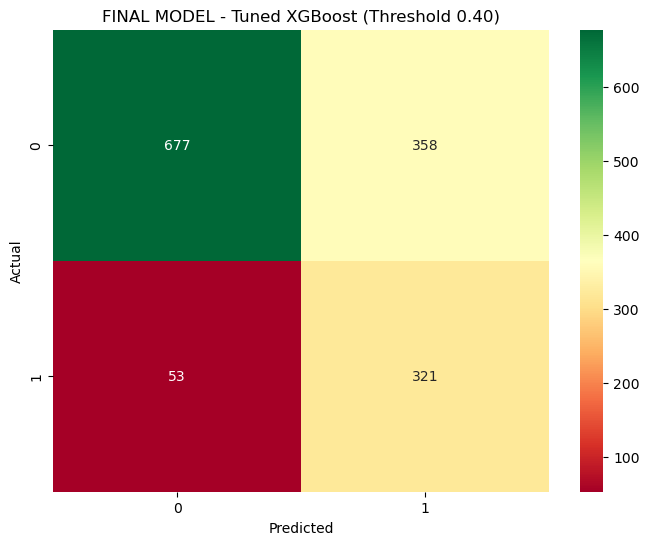


📊 Business Impact:
Missed churners: 53
Revenue at risk: $81,196
False alarms: 358
Wasted retention cost: $17,900


In [102]:
# Set optimal threshold
optimal_threshold = 0.40  # or 0.45

y_pred_final = (y_pred_proba_tuned >= optimal_threshold).astype(int)

print("🏆 FINAL MODEL - Tuned XGBoost (Threshold 0.40):")
print(classification_report(y_test, y_pred_final))

cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='RdYlGn')
plt.title('FINAL MODEL - Tuned XGBoost (Threshold 0.40)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"\n📊 Business Impact:")
print(f"Missed churners: {cm_final[1][0]}")
print(f"Revenue at risk: ${cm_final[1][0] * 1532:,.0f}")
print(f"False alarms: {cm_final[0][1]}")
print(f"Wasted retention cost: ${cm_final[0][1] * 50:,.0f}")

TOP 15 MOST IMPORTANT FEATURES
                       feature  importance
                      Contract    0.184858
                 FiberNoAddons    0.107566
   InternetService_Fiber optic    0.072217
                NewHighSpender    0.066251
            InternetService_No    0.052232
               HighRiskProfile    0.052170
             ChargeTenureRatio    0.045260
      PaperlessElectronicCheck    0.035152
PaymentMethod_Electronic check    0.029694
                OnlineSecurity    0.021321
               StreamingMovies    0.020907
              PaperlessBilling    0.020670
                   StreamingTV    0.019404
                        tenure    0.017795
                 IsNewCustomer    0.017520

📊 Top 10 features: ['Contract', 'FiberNoAddons', 'InternetService_Fiber optic', 'NewHighSpender', 'InternetService_No', 'HighRiskProfile', 'ChargeTenureRatio', 'PaperlessElectronicCheck', 'PaymentMethod_Electronic check', 'OnlineSecurity']


/var/folders/db/2ctyhrqd5xqdw7k9vlznfq3h0000gn/T/ipykernel_2141/1151379457.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), y='feature', x='importance', palette='rocket')


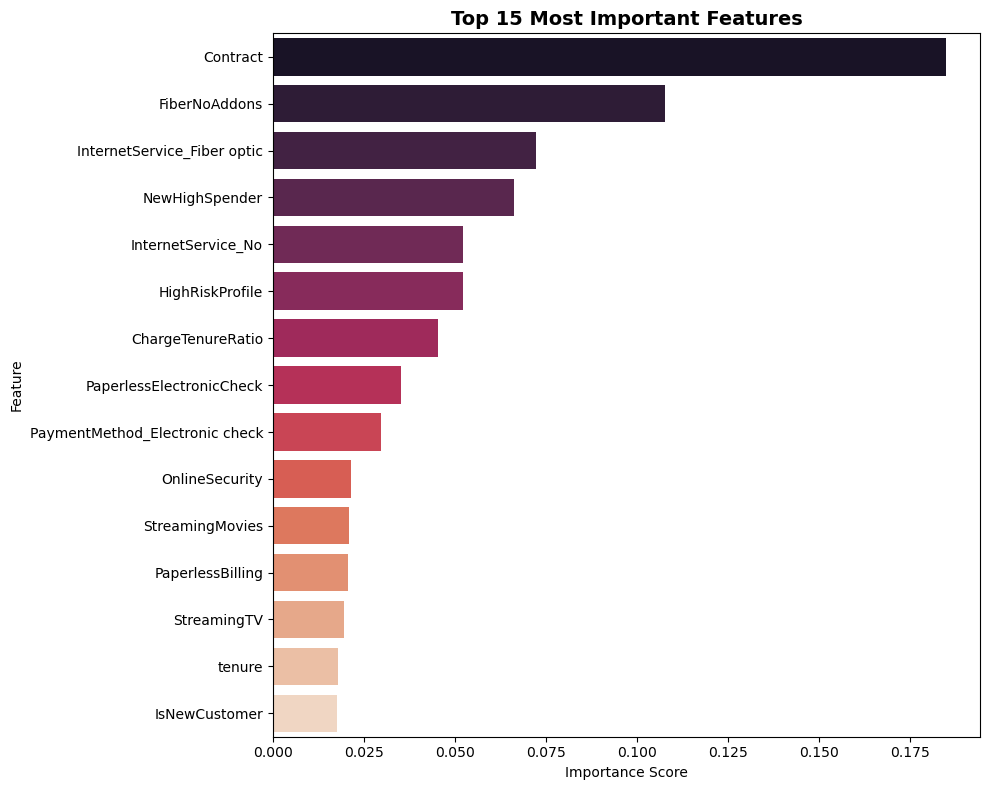

In [118]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': xgb_random.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("="*60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(15).to_string(index=False))

# Save top features list
top_features = feature_importance.head(10)['feature'].tolist()
print(f"\n📊 Top 10 features: {top_features}")

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance', palette='rocket')
plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()